# Practice 2. Convolutional networks. Pytorch.

Before starting the assignment, make this notebook `Trusted` for valid display of images:

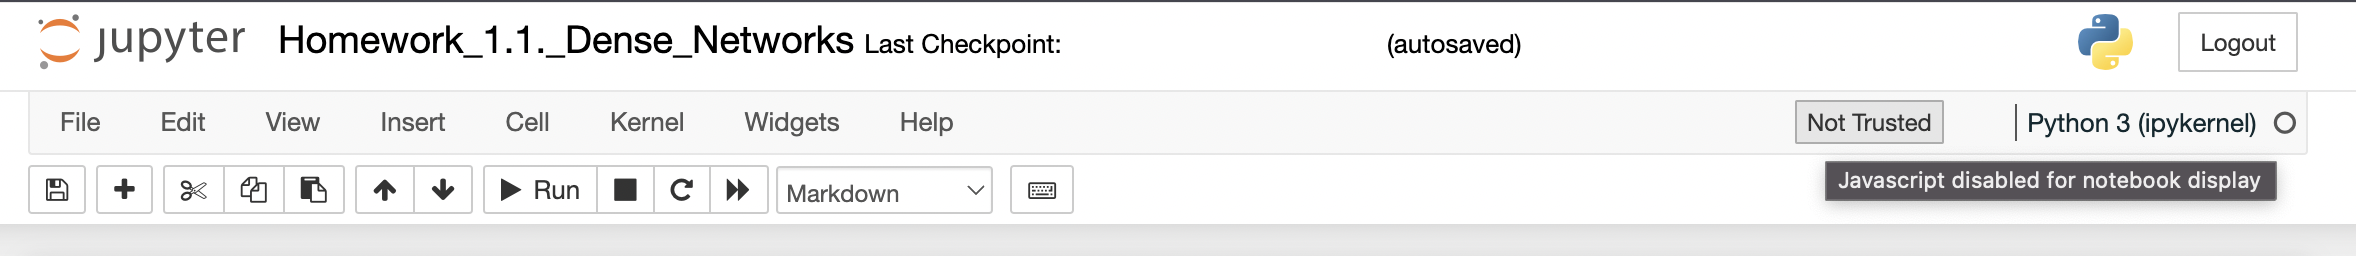

In [324]:
import matplotlib.pyplot as plt
from torch.nn.functional import batch_norm
%matplotlib inline

In [325]:
import numpy as np

import torch

In the previous assignment, we practiced in using the Pytorch framework, writing our own modules, and implementing a training cycle on a toy dataset with a small number of objects of rather low resolution. Now we will use ready-made implementations of layers for a neural network and we will test models on data of moderately large size and resolution.

Just like in the previous task, we will solve the problem of multi-class classification. At the same time, instead of fully connected networks, we will construct a convolutional network, which, due to its inductive bias, usually works better in computer vision (CV) tasks.

This time we'll start by loading and preprocessing the training data. Pytorch implements a ready-made set of classes and functions for working with data sets. Typically, when working with **Pytorch**, a dataset is represented as a descendant of the `torch.utils.data.Dataset` class:
```python
class DatasetExample(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        
    def __getitem__(self, idx):
        '''
        Returns a dataset element by its index
        :param int idx: Element index in the dataset
        :returns: Object from the selection with serial number idx
        '''
        ...
        
    def __len__(self):
        '''
        Optional method, returns the number of elements in the dataset
        '''
        ...
```

Basic tools to work with images in **Pytorch** are included in a separate module `torchvision`. This library allows you to:
* Load and work with popular computer vision datasets
* Apply transformations to images in `PIL`, `numpy.ndarray` and `torch.Tensor` formats
* Use CV-specific blocks and loss functions
* Use ready-made CV model architectures (including pre-trained models)

All datasets in the `torchvision` library are inherited from `torch.utils.data.Dataset`. Also, almost all datasets have class constructor arguments `transforms` and `target_transform`, which specify transformations to be applied to network inputs (usually images) and targets (usually class labels), respectively. Main use cases for transformations include:
* Convert images from one format to another. For example, datasets usually store and return images in `PIL` format, while images must be transferred to the neural network in the form of `torch.Tensor`
* Normalization and augmentation of images
* Normalization of class labels, that is, converting them and their string representation into a numerical one

The `torchvision` library contains a large set of [ready-made transformations](https://pytorch.org/vision/stable/transforms.html).

To work with the `CIFAR10` dataset we will need the following of them:
* `torchvision.transforms.ToTensor` - converting a `PIL` image to `torch.Tensor`
* `torchvision.transforms.Normalize` - image normalization in `torch.Tensor` format
* `torchvision.transforms.Compose` - a class that allows you to combine several successive transformations into one

In [326]:
import torchvision

Let's load the `CIFAR10` dataset and look at its contents:

In [327]:
# Pay attention to the function arguments:
#     train is responsible for which split should be used, that is, train or test set
#     download is responsible for downloading the dataset from the Internet
ds_train_no_transform = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=None, download=True
)

Files already downloaded and verified


Dataset description:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

Dataset object — PIL image and label: (<PIL.Image.Image image mode=RGB size=32x32 at 0x7C11BCCD1760>, 6)



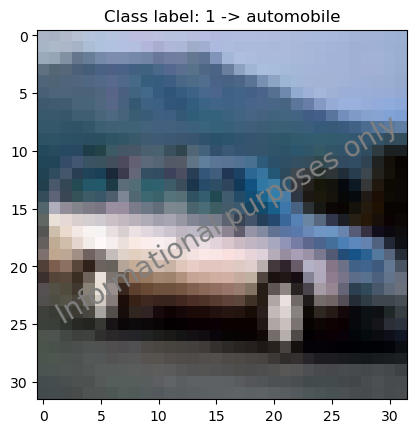

In [328]:
print(f'Dataset description:\n{ds_train_no_transform}\n')
print(f'Dataset object — PIL image and label: {ds_train_no_transform[0]}\n')

image, label = ds_train_no_transform[4]

plt.imshow(image)

plt.text(
    16.0, 16.0, 'Informational purposes only',
    fontsize=20, color='gray', alpha=1.0,
    ha='center', va='center', rotation=30
)

plt.title(f'Class label: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Let's create a `transform` for the image, which will convert it from `PIL` format to `torch.Tensor`, and then normalize it:

In [329]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # We use mean and standard deviation calculated for the CIFAR10 dataset
    # https://github.com/kuangliu/pytorch-cifar/issues/16
    torchvision.transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

Apply transform to the image:

Image type before transform: <class 'PIL.Image.Image'>. Size: (32, 32). Image type: RGB
Image type after transform: <class 'torch.Tensor'>. Size: torch.Size([3, 32, 32])


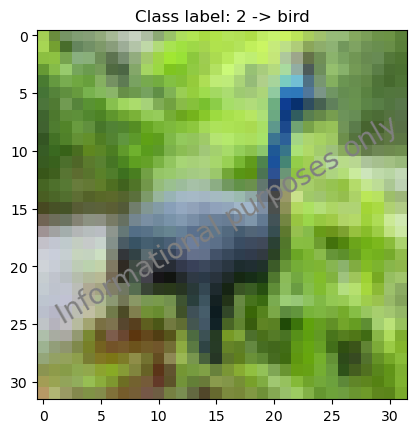

In [330]:
image, label = ds_train_no_transform[6]
print(f'Image type before transform: {type(image)}. Size: {image.size}. Image type: {image.mode}')

image_tensor = transform(image)
print(f'Image type after transform: {type(image_tensor)}. Size: {image_tensor.shape}')

plt.imshow(image)

plt.text(
    16.0, 16.0, 'Informational purposes only',
    fontsize=20, color='gray', alpha=1.0,
    ha='center', va='center', rotation=30
)

plt.title(f'Class label: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Create datasets with a train and test split of the `CIFAR10` dataset. Don't forget to pass the transform.

In [331]:
### your code here
ds_train = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=transform, download=True
)
ds_test = torchvision.datasets.CIFAR10(
    root='./', train=False, transform=transform, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [332]:
ds_train, ds_test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

For convenience, we immediately define the inverse transformation, which makes a PIL image from a tensor that can be correctly displayed:

In [333]:
tmean, tstd = transform.transforms[1].mean, transform.transforms[1].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd,
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

Let's look at a few images from the train and test sets:

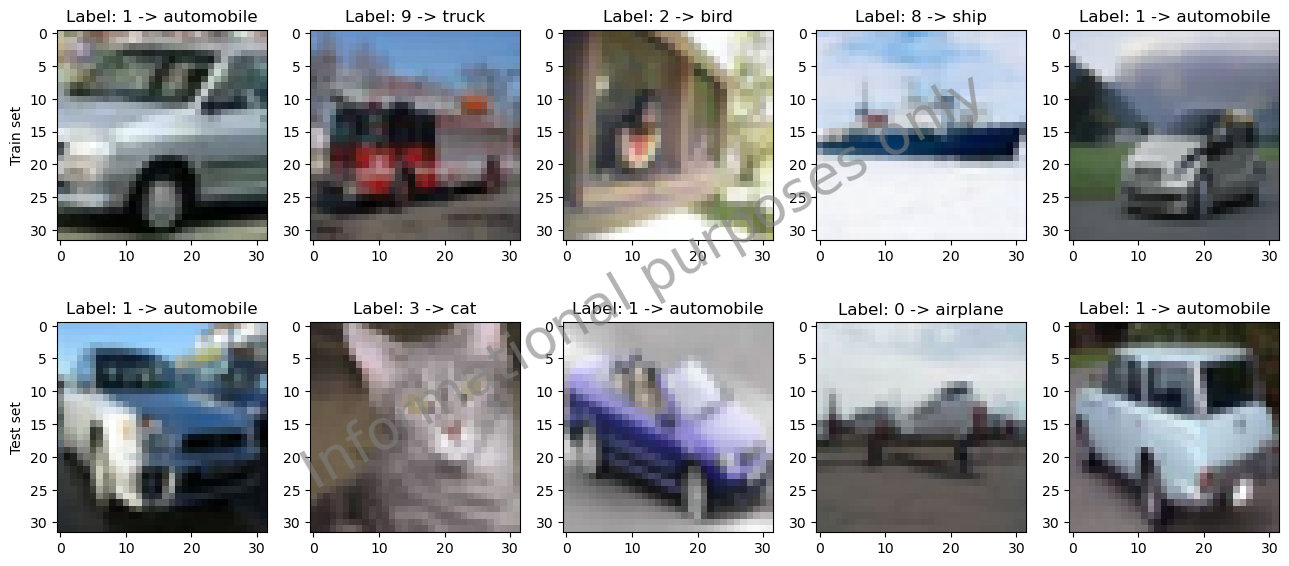

In [334]:
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((ds_train, ds_test)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(inverse_transform(image))
        axes[idx, jdx].set_title(f'Label: {label} -> {ds.classes[label]}')

axes[0, 0].set_ylabel('Train set')
axes[1, 0].set_ylabel('Test set')

fig.text(
    0.5, 0.5, 'Informational purposes only',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation=30
)

fig.tight_layout()
plt.show()

In the previous task, we used an optimizer that required calculating the gradient over the entire sample. However, in practice, stochastic optimization methods are usually applied, which use batches of objects sampled from the training set. Although mixing and batching objects from a dataset can be done manually, **Pytorch** allows you to do these operations much more efficiently. To do this, they usually use a class that converts the dataset into a batch generator `torch.utils.data.DataLoader`. This wrapper allows you to combine objects into one batch, that is, combine the corresponding tensors in each object (for example, images and corresponding labels).

Basic parameters of the dataloader:
- `batch_size` — subsample size sampled each time the instance is accessed
- `shuffle` — shuffle the selection or not
- `num_workers` is a key parameter that determines the performance of the batch generator. Let us describe the influence of this parameter in more detail. In the process of generating the next batch, the dataloader must perform several slow procedures: requesting objects from the corresponding dataset, which often includes reading from the hard drive (since large datasets do not fit in RAM), applying transforms to all images and concatenating individual objects into one tensor. It often turns out that calculating a forward pass through the network occurs faster than the next batch is generated, which leads to a significantly inefficient program. In this case, it is necessary to increase the number of parallel processes, each of which generates another batch of data. In practice, choosing the right number of workers can give a multiple increase in speed (usually, the search starts with $3-4$ workers)

Create dataloaders for CIFAR10 training and test samples. Note that the training set must be shuffled with each pass through the sample, but the test set must not.

In [335]:
batch_size = 128

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=10)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=10)

Let's look at the batch from the dataloader:

In [336]:
images, labels = next(iter(dl_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


We will implement a convolutional VGG-like network. The network will consist of three main blocks:
1. Convolutional feature extractor
     * This sequence of layers takes as input an image with $3$ channels
     * The sequence of layers is specified by the `cfg` configuration list:
         - The number means the number of output channels of the next convolution. Use convolutions with kernel $3\times3$ and padding $1$
         - `"M"` means Max Pooling layer. Each such layer should reduce the spatial dimensions of the image by $2$ times
2. Adaptive Average Pooling Layer
     - Use output spatial resolution $2\times2$
3. Fully connected "head" classifier with $2$ hidden layers of $128$ dimension

* Use `ReLU` as activation function everywhere
* Depending on the `use_batchnorm` flag, add a batchnorm after each convolutional layer
* Between fully connected layers, add `Dropout` layers with the value $p = \text{dropout_p}$
* Use only ready-made modules from `torch.nn`. To combine layers into blocks, use `torch.nn.Sequential`

In [337]:
class ConvNet(torch.nn.Module):
    cfg = [32, "M", 64, 64, "M", 128, 128, "M"]

    def __init__(self, n_classes=10, use_batchnorm=False, dropout_p=0.0):
        '''
        :param int n_classes: Number of output features
        :param bool use_batchnorm: Whether to use batchnorm between convolutional layers
        :param float dropout_p: Probability of the activation being reset by the Dropout layer
        '''
        super().__init__()
        
        self.n_classes = n_classes
        
        layers = []
        in_channels = 3
        for x in ConvNet.cfg:
            if x == "M":
                layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
            elif type(x) == int:
                layers.append(torch.nn.Conv2d(in_channels, x, kernel_size=3, stride=1, padding=1))
                layers.append(torch.nn.ReLU())
                in_channels = x
                if use_batchnorm:
                    layers.append(torch.nn.BatchNorm2d(x))
            else:
                raise ValueError(f"cfg must contain either 'M' or int, not '{x}'")
        
        self.features = torch.nn.Sequential(*layers)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            
            torch.nn.Dropout(dropout_p),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            
            torch.nn.Dropout(dropout_p),
            torch.nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # features = self.features(x)
        # avg = self.avgpool(features)
        # return self.classifier(avg.flatten(start_dim=1))
        return torch.nn.Sequential(
            self.features,
            self.avgpool,
            torch.nn.Flatten(start_dim=1),
            self.classifier
        ).forward(x)
        

Check that your network implementation passes the minimal tests:

In [338]:
assert sum(buffer.numel() for buffer in ConvNet(use_batchnorm=True).buffers()) == 837
assert sum(param.numel() for param in ConvNet(use_batchnorm=True).parameters()) == 362058
assert sum(param.numel() for param in ConvNet(use_batchnorm=False).parameters()) == 361226

sample_image = torch.randn([11, 3, 32, 32])
sample_model = ConvNet(use_batchnorm=False, dropout_p=0.5)
assert torch.all(torch.ne(sample_model.train()(sample_image), sample_model.eval()(sample_image)))

assert list(ConvNet().features(sample_image).shape) == [11, 128, 4, 4]
assert list(ConvNet().avgpool(ConvNet().features(sample_image)).shape) == [11, 128, 2, 2]
assert list(ConvNet()(sample_image).shape) == [11, 10]

We will use cross-entropy as a loss function, as in the previous task, but this time its ready-made implementation. As an optimizer, let's take the most common optimizer in machine learning - SGD:

In [339]:
conv_network = ConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

Let's define a device for calculations and transfer the model to it:

In [340]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

print(type(device), device)

<class 'torch.device'> cpu


In [341]:
conv_network.to(device)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bi

It is only left to implement the training cycle for the neural network. Since this task will use the SGD optimizer, there is no need to implement the optimization step through a closure function. Implement the optimization step in any convenient way.

In [342]:
import tqdm.notebook as tqdm
from functools import partial

In [343]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device):
    '''
    :param int n_epochs: Number of optimization epochs
    :param torch.nn.Module network: Neural network
    :param Callable loss_fn: Loss function
    :param torch.nn.Optimizer optimizer: Optimizer
    :param torch.utils.data.DataLoader dl_train: Dataloader for the train set
    :param torch.utils.data.DataLoader dl_test: Dataloader for the test set
    :param torch.Device device: Computation device
    :returns: Lists of loss function and accuracy values on the training and test samples after each epoch
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)):
        # Switch the network to train mode
        network.train()

        # Training epoch
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            # Implement the optimization step.
            # It is not necessary to use a closure function to pass it to the optimizer.
            # You can move the calculation of gradients out of the function into the loop itself.
            def closure(images, labels):
                '''
                Closure function for calculating the gradients of the loss function over the training set:
                     1. Zero out current gradients
                     2. Perform a forward pass through the network to compute the loss function
                     3. Compute the gradients of the loss function

                To pass arguments to a closure function, you can use the partial function
                :returns: Loss function value
                '''
                optimizer.zero_grad()
                loss = loss_fn(network.forward(images), labels)
                loss.backward()
                return loss

            # Optimization step
            optimizer.step(partial(closure, images.to(device), labels.to(device)))

        # Evaluate the model once per 3 epochs
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            def eval_network(network, loss_fn, dl):
                loss = 0
                n_correct = 0
                n_total = 0
                for images, labels in tqdm.tqdm(dl, total=len(dl), leave=False):
                    y_pred = network.forward(images.to(device))
                    labels = labels.to(device)
                    loss += loss_fn(y_pred, labels)
                    n_correct += (torch.argmax(y_pred, 1) == labels).sum()
                    n_total += labels.shape[0]
                return loss, n_correct / n_total * 100
            
            # Switch network to the evaluation mode
            network.eval()

            with torch.no_grad():
                # Calculate accuracy and loss on a train sample
                loss, acc = eval_network(network, loss_fn, dl_train)
                train_losses.append(loss.cpu())
                train_accuracies.append(acc.cpu())

                # Calculate accuracy and loss on a test sample
                loss, acc = eval_network(network, loss_fn, dl_test)
                test_losses.append(loss.cpu())
                test_accuracies.append(acc.cpu())

            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )

    return train_losses, test_losses, train_accuracies, test_accuracies


Finally, everything is ready to train the model:

In [ ]:
n_epochs = 100
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

**Task 1.** Let’s plot quality curves for training and testing:

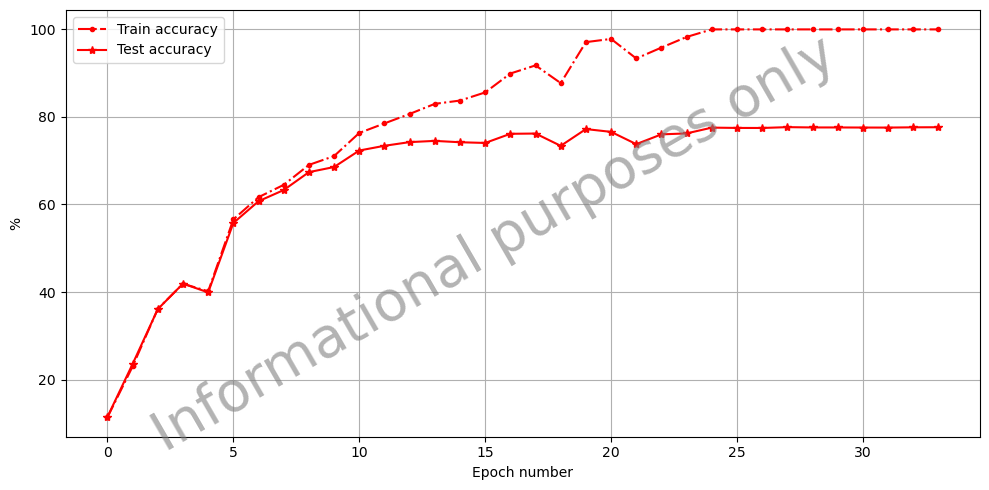

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Train accuracy", color='red', marker='.', linestyle='-.')
ax.plot(test_accs, label="Test accuracy", color='red', marker='*')

ax.set_xlabel("Epoch number")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.5, 0.5, 'Informational purposes only',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation=30
)

fig.tight_layout()
plt.show()

**Task 2.** Now, for comparison, train models with batchnorm, dropout (use $p=0.5$) and both. Don’t forget to save all the metrics so that you can then compare all the $4$ models considered on one plot:

In [237]:
conv_network = ConvNet(dropout_p=0.5)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)
train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network = ConvNet(use_batchnorm=True)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)
train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)
train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

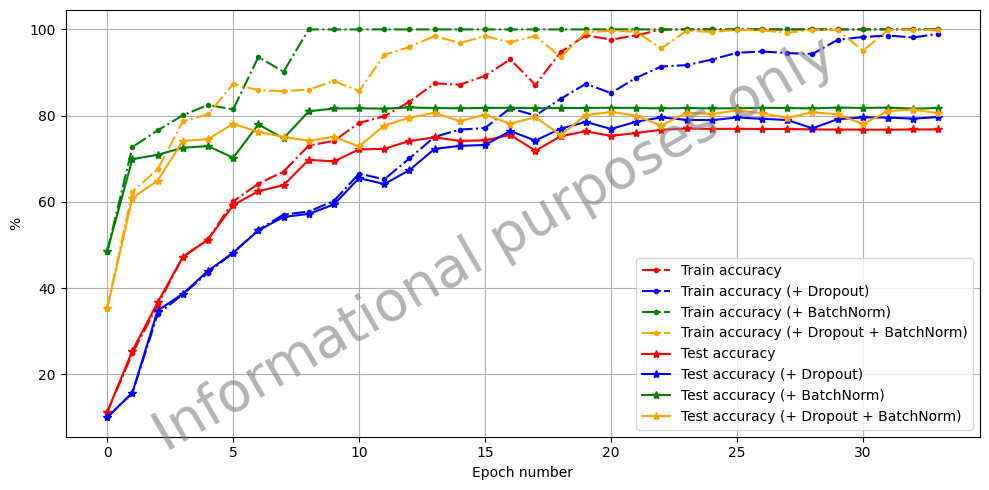

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Train accuracy", color='red', marker='.', linestyle='-.')
ax.plot(train_accs_dp, label="Train accuracy (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(train_accs_bn, label="Train accuracy (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(train_accs_bn_dp, label="Train accuracy (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(test_accs, label="Test accuracy", color='red', marker='*')
ax.plot(test_accs_dp, label="Test accuracy (+ Dropout)", color='blue', marker='*')
ax.plot(test_accs_bn, label="Test accuracy (+ BatchNorm)", color='green', marker='*')
ax.plot(test_accs_bn_dp, label="Test accuracy (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Epoch number")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.5, 0.5, 'Informational purposes only',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation=30
)

fig.tight_layout()
plt.show()

Give detailed answers to the questions (in the same cell):
1. Which network performed best?
2. How do batch norms and dropouts affect the final quality during training and testing?
3. How do these modifications affect the convergence speed of training?

__Answers:__

*Your answers here*

Once a model has been trained, its weights typically need to be stored. **Pytorch** provides a separate interface for saving and loading model weights later. First, the information needed to restore the state of the model can be obtained through the `state_dict` method of the `torch.nn.Module` class. By default, this method returns a dictionary with all **non-null parameters and model buffers**. The reverse method `load_state_dict` allows you to set the values of parameters and buffers from a dictionary. Secondly, to save weights to disk and then load them from disk, use the `torch.save` and `torch.load` methods.

Let's look at this procedure using an example:

In [ ]:
state_dict = conv_network.state_dict()
print(state_dict)

OrderedDict([('features.0.weight', tensor([[[[ 5.6846e-02,  2.9020e-01, -4.0348e-01],
          [-4.0314e-01,  5.7471e-01, -5.5706e-02],
          [-1.3831e-01, -2.0172e-01,  2.1021e-01]],

         [[ 3.1993e-03,  3.9536e-02, -2.1648e-01],
          [-2.0017e-01,  6.4483e-01,  1.1597e-01],
          [-2.2536e-01, -3.0000e-01,  2.8058e-01]],

         [[ 1.8928e-01,  5.6350e-02, -4.5861e-01],
          [-1.8902e-01,  5.1483e-01,  1.0888e-01],
          [ 1.2979e-01, -4.6297e-01,  2.4074e-02]]],


        [[[-2.4408e-01,  1.5421e-01,  8.4436e-02],
          [-1.7679e-01, -1.8780e-01,  2.5255e-01],
          [ 2.8313e-01, -3.2594e-01,  5.1873e-02]],

         [[-3.4475e-01,  1.9160e-01,  2.1995e-01],
          [-2.1199e-01, -1.6521e-01,  3.3713e-01],
          [ 9.8396e-02, -1.1270e-01, -1.7122e-04]],

         [[-3.9856e-01,  2.3528e-01,  2.5599e-01],
          [-3.6181e-01, -1.3195e-01,  4.3721e-01],
          [-1.1753e-01, -1.0798e-01,  2.1933e-01]]],


        [[[ 1.6957e-01,  7.4240

In [ ]:
torch.save(state_dict, 'conv_weights.pt')

In [ ]:
import os
os.listdir()

Note that when working in **Google Colab**, the saved files will only exist while the corresponding Jupyter Notebook is running. When you reboot, this data will be cleared. To solve this problem, you can save the weights to your personal **Google Drive**, having first mounted it with the following command:
```python
from google.colab import drive
drive.mount('/content/drive')
```

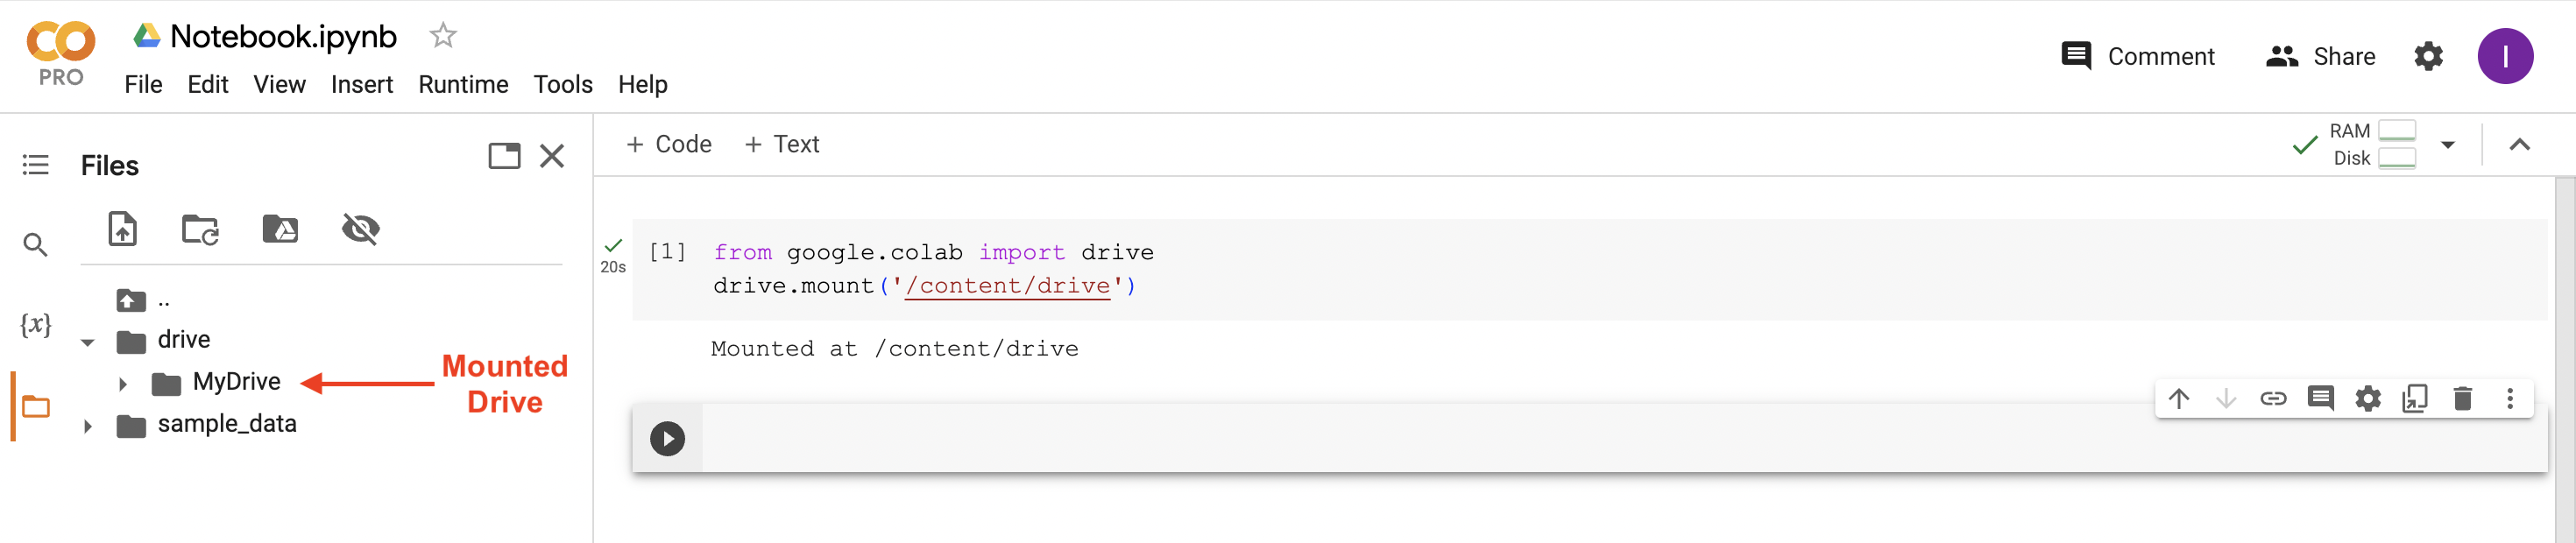

Now let’s load the weights into the "clean" model:

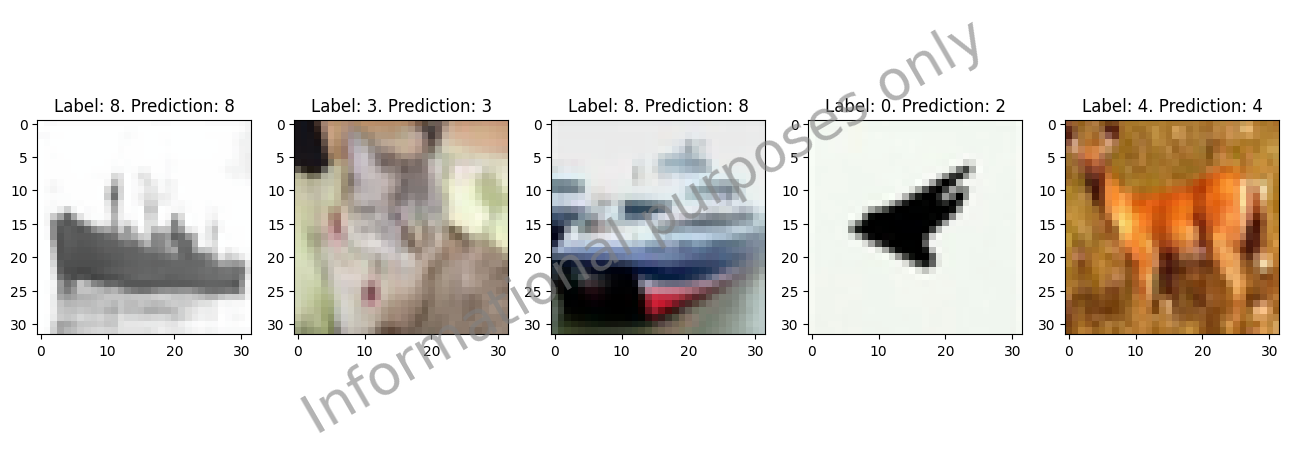

In [ ]:
state_dict = torch.load('conv_weights.pt')

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
conv_network.load_state_dict(state_dict)

images, labels = next(iter(dl_test))

logits = conv_network(images)
predictions = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(inverse_transform(images[jdx]))
    axes[idx].set_title(f'Label: {labels[jdx]}. Prediction: {predictions[jdx]}')

fig.text(
    0.5, 0.5, 'Informational purposes only',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation=30
)

fig.tight_layout()
plt.show()

Note that loading model weights using `torch.load` (as well as using any other [`pickle`](https://docs.python.org/3/library/pickle.html) derived functions) is [**unsafe operation**](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load). During the boot process, absolutely any Python code can potentially be executed. Therefore, use only those pre-trained models that you trust.

For example, try loading weights modified in a special way:

In [ ]:
torch.load('conv_weights_pretrained.pt')

<IPython.core.display.Javascript object>

{'features.0.weight': tensor([[[[ 0.0135, -0.1222, -0.0140],
           [-0.0583, -0.0326, -0.0327],
           [ 0.0364, -0.0228, -0.0144]],
 
          [[-0.1221,  0.0279, -0.0010],
           [ 0.1580,  0.0674, -0.1431],
           [-0.0802,  0.1627,  0.1680]],
 
          [[ 0.0060, -0.1505, -0.1332],
           [-0.1881,  0.0770,  0.1451],
           [ 0.1693,  0.1653, -0.0989]]],
 
 
         [[[-0.1572,  0.0840,  0.1532],
           [-0.1795,  0.1075,  0.0705],
           [ 0.0207, -0.1909,  0.0500]],
 
          [[-0.0900,  0.1825,  0.1370],
           [-0.0408, -0.1705, -0.0184],
           [ 0.1715,  0.0555, -0.0777]],
 
          [[-0.0672,  0.1577,  0.0703],
           [ 0.1888,  0.0674,  0.0603],
           [-0.1027, -0.1378,  0.0135]]],
 
 
         [[[-0.0790, -0.0692, -0.1516],
           [-0.1701,  0.1475,  0.0321],
           [-0.0049,  0.1399,  0.1633]],
 
          [[ 0.0734,  0.0740,  0.1897],
           [ 0.0612, -0.0136, -0.1917],
           [-0.0429,  0.0188, -0